In [58]:
!pip install pytorch-forecasting
!pip install torch torchvision torchaudio
!pip install optuna

Import Libraries

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Load Data & Preprocess Data

In [60]:
train_file = "..\\Data\\Train\\trains1990s.csv"
df = pd.read_csv(train_file, parse_dates=['observation_date'])

df.columns = df.columns.str.replace('.', '_', regex=False)
df.rename(columns={'observation_date': 'Date', 'fred_PCEPI': 'Inflation'}, inplace=True)
df['time_idx'] = range(len(df))  # Create numerical time index

# ADD TIME FEATURES
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# CREATE LAGGED FEATURES
lags = [1, 3, 6, 12]
for lag in lags:
    df[f'Inflation_Lag{lag}'] = df['Inflation'].shift(lag)

# Drop NaN rows due to lagging
df.dropna(inplace=True)

<ipython-input-60-e72d1e83d671>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(train_file, parse_dates=['observation_date'])


Feature Selection & Normalization

In [61]:
features = ['Inflation'] + [f'Inflation_Lag{lag}' for lag in lags] + ['Year', 'Month', 'Quarter']
target = 'Inflation'

# 🚀 NORMALIZE FEATURES
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 🚀 SPLIT DATA INTO TRAIN & VALIDATION
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=False)

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]

Hyperparameter Tuning with Optuna

In [62]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)


[I 2025-03-10 23:36:56,969] A new study created in memory with name: no-name-862cc8d4-f8fe-4d6e-b7e9-f9b186aec28f
[I 2025-03-10 23:37:03,229] Trial 0 finished with value: 0.4590692192144025 and parameters: {'learning_rate': 0.04764635104923626, 'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6039238402863935, 'colsample_bytree': 0.9399494058874556, 'reg_lambda': 9.24480706701677, 'reg_alpha': 1.4551259709849365, 'n_estimators': 2902}. Best is trial 0 with value: 0.4590692192144025.
[I 2025-03-10 23:37:04,744] Trial 1 finished with value: 0.5188880643877345 and parameters: {'learning_rate': 0.08905670234204338, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5557027952673232, 'colsample_bytree': 0.6741556936532662, 'reg_lambda': 9.550959666229478, 'reg_alpha': 2.5475100131253514, 'n_estimators': 1192}. Best is trial 0 with value: 0.4590692192144025.
[I 2025-03-10 23:37:06,575] Trial 2 finished with value: 0.6584113423041694 and parameters: {'learning_rate': 0.04155009060503

Train Final XGBoost Model

In [63]:
best_params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eval_metric": "rmse",
    **study.best_params
}

best_model = xgb.XGBRegressor(**best_params)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1.64912
[1]	validation_0-rmse:1.61223
[2]	validation_0-rmse:1.57785
[3]	validation_0-rmse:1.54321
[4]	validation_0-rmse:1.50995
[5]	validation_0-rmse:1.47943
[6]	validation_0-rmse:1.44823
[7]	validation_0-rmse:1.41641
[8]	validation_0-rmse:1.38580
[9]	validation_0-rmse:1.36027
[10]	validation_0-rmse:1.33296
[11]	validation_0-rmse:1.31037
[12]	validation_0-rmse:1.28522
[13]	validation_0-rmse:1.25902
[14]	validation_0-rmse:1.23441
[15]	validation_0-rmse:1.21095
[16]	validation_0-rmse:1.18519
[17]	validation_0-rmse:1.16012
[18]	validation_0-rmse:1.13745
[19]	validation_0-rmse:1.11933
[20]	validation_0-rmse:1.09669
[21]	validation_0-rmse:1.07628
[22]	validation_0-rmse:1.05456
[23]	validation_0-rmse:1.03494
[24]	validation_0-rmse:1.01782
[25]	validation_0-rmse:0.99914
[26]	validation_0-rmse:0.98125
[27]	validation_0-rmse:0.96322
[28]	validation_0-rmse:0.94712
[29]	validation_0-rmse:0.93085
[30]	validation_0-rmse:0.91617
[31]	validation_0-rmse:0.90143
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9914592182229085, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.042363929995002485,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1709, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Predict on Validation Set

In [64]:
predictions = best_model.predict(X_val)

# Convert predictions back to original scale
pred_values = scaler.inverse_transform(
    np.hstack([predictions.reshape(-1, 1), np.zeros((len(predictions), len(features)-1))])
)[:, 0]

# Get actual values from val_df
actual_values = scaler.inverse_transform(
    np.hstack([y_val.values.reshape(-1, 1), np.zeros((len(y_val), len(features)-1))])
)[:, 0]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Date": val_df["Date"],
    "Actual": actual_values.flatten(),
    "Predicted": pred_values.flatten()
})

Evaluation Metrics

In [65]:
xgb_rmse = np.sqrt(mean_squared_error(comparison_df["Actual"], comparison_df["Predicted"]))
xgb_r2 = r2_score(comparison_df["Actual"], comparison_df["Predicted"])

print(f" XGBoost Model RMSE: {xgb_rmse:.4f}")
print(f" XGBoost Model R² Score: {xgb_r2:.4f}")

 XGBoost Model RMSE: 4.5386
 XGBoost Model R² Score: -1.8072


Visualization

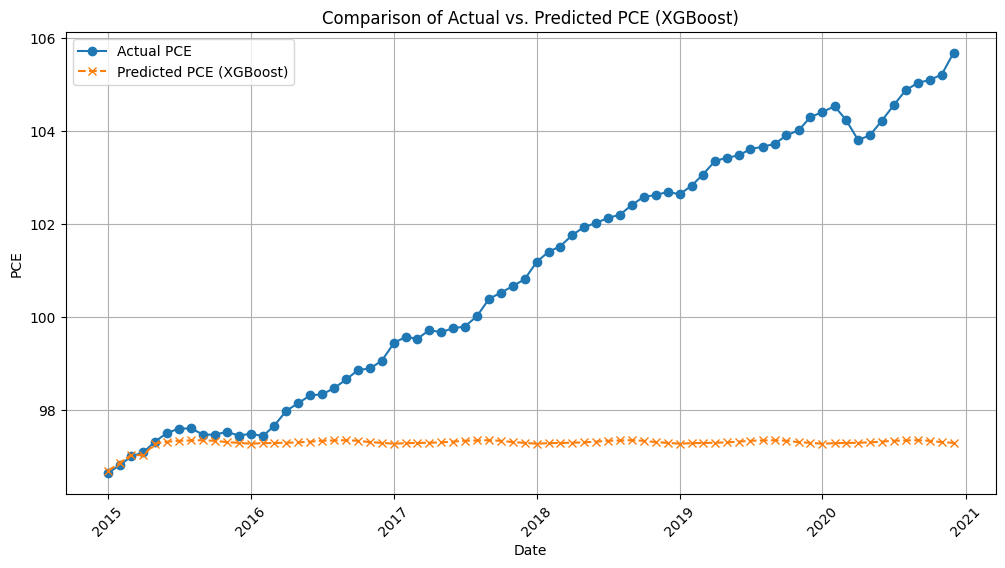

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["Date"], comparison_df["Actual"], label="Actual PCE", marker="o", linestyle="-")
plt.plot(comparison_df["Date"], comparison_df["Predicted"], label="Predicted PCE (XGBoost)", marker="x", linestyle="--")
plt.xlabel("Date")
plt.ylabel("PCE")
plt.title("Comparison of Actual vs. Predicted PCE (XGBoost)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()